In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_9947330d5f2a4f79bb12b8e293a0ec9a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='w_rmVOvL-NG6iKsxFVpyJWpcBFldQ3AoeACI-8zivN0X',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_9947330d5f2a4f79bb12b8e293a0ec9a.get_object(Bucket='myproject-donotdelete-pr-uqfcq09yc9ajmo',Key='T1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f133d01e128>,
      dtype=object)

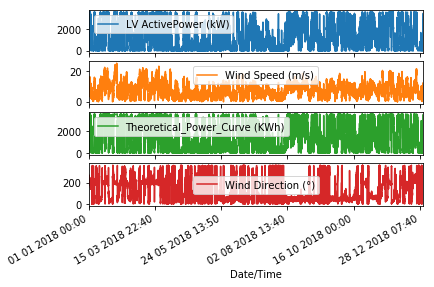

In [3]:
#print(df)
print(df.columns)
features_considered = ['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
features = df[features_considered]
features.index = df['Date/Time']
features.head()
features.plot(subplots=True)

In [4]:
#dataset scaling
TRAIN_SPLIT=(int)(len(df)*0.6)
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [8]:
dataset

array([[-0.58837296, -0.41587088, -0.67426828,  1.26596201],
       [-0.53091726, -0.33330579, -0.59752468,  1.35596934],
       [-0.64578953, -0.43767719, -0.69310728,  1.39681493],
       ...,
       [ 0.83089226,  0.29896597,  0.34214503, -0.55842135],
       [ 1.0760697 ,  0.52458367,  0.80895287, -0.56304952],
       [ 1.31359755,  0.65225717,  1.07625269, -0.58411207]])

In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [9]:
past_history = 60
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target  to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (60, 4)

 Target  to predict : (6,)


In [10]:
BATCH_SIZE = 512
BUFFER_SIZE = BATCH_SIZE*BATCH_SIZE

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [11]:
def create_time_steps(length):
  return list(range(-length, 0))

In [14]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [15]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

RuntimeError: dataset.__iter__() is only supported when eager execution is enabled.

In [16]:
#creating new trained model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(216,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.4))
multi_step_model.add(tf.keras.layers.LSTM(60, activation='relu'))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
multi_step_modell = client_9947330d5f2a4f79bb12b8e293a0ec9a.get_object(Bucket='myproject-donotdelete-pr-uqfcq09yc9ajmo', Key='Trained_Model.h5')['Body']
# add missing __iter__ method so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 


In [22]:
EVALUATION_INTERVAL = 36
EPOCHS = 10
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=36)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
36/36 [==============================] - 96s 3s/step - loss: 0.5161 - val_loss: 0.3058
Epoch 2/10
36/36 [==============================] - 88s 2s/step - loss: 0.3394 - val_loss: 0.2341
Epoch 3/10
36/36 [==============================] - 89s 2s/step - loss: 0.3049 - val_loss: 0.2458
Epoch 4/10
36/36 [==============================] - 88s 2s/step - loss: 0.2879 - val_loss: 0.2283
Epoch 5/10
36/36 [==============================] - 88s 2s/step - loss: 0.2730 - val_loss: 0.2354
Epoch 6/10
36/36 [==============================] - 89s 2s/step - loss: 0.2652 - val_loss: 0.2074
Epoch 7/10
36/36 [==============================] - 88s 2s/step - loss: 0.2596 - val_loss: 0.2017
Epoch 8/10
36/36 [==============================] - 90s 2s/step - loss: 0.2529 - val_loss: 0.1990
Epoch 9/10
36/36 [==============================] - 89s 2s/step - loss: 0.2486 - val_loss: 0.2000
Epoch 10/10
36/36 [==============================] - 88s 2s/step - los

In [23]:
#save trained model
multi_step_model.save('Trained_Model.h5')

In [24]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

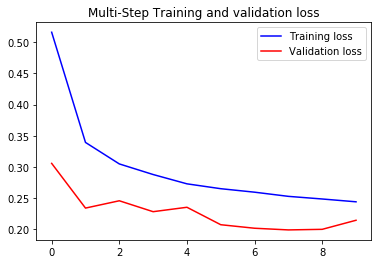

In [25]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [26]:
multi_step_modell = tf.keras.models.load_model('Trained_Model.h5')
for x, y in val_data_multi.take(6):
  for i in range(0,6):
    #upscaled result
    print((multi_step_model.predict(x)[0][i]*data_std)+data_mean)
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

RuntimeError: dataset.__iter__() is only supported when eager execution is enabled.